<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="5"> TAF MCE - 2022</span></p>
<p><font size="4">  UE SLSR  </font></p>
<p></p>
<p><font size="5">  TP - Reconstruction de signaux sparse </font></p>
<p><font size="4">Student Name: Zuoyu Zhang</font></p></br>
</p>
</CENTER>

**1 Introduction**

Dans le cadre de ce TP vous avez pour objectifs de mettre en œuvre des méthodes de reconstruction de signaux sparse, de les évaluer en terme de performances de reconstruction et complexité et d’évaluer leurs robustesse par rapport au niveau de bruit. Pour cette session, le travail se déroule binôme ou seul et le choix du langage est libre entre Julia, Matlab et Python.

Ici, nous importons d'abord quelques bibliothèques nécessaires à utiliser plus tard. 

In [30]:
import numpy as np
import cvxpy as cp
import time
import matplotlib.pyplot as plt

np.random.seed(123)
N_iter = 10

**2 Génération des données**

Soit $x ∈ R^N$ un signal sparse avec $K$ éléments non-nuls et soit la matrice $A ∈ R^{n×N}$ une matrice aléatoire tel que : $$y =Ax$$. 

**Question 1) En utilisant les paramètres suivants $N = 500$, $n = 250$ et $K = 10$ générez le système précédent. Pour générer la matrice $\mathbf{A}$ vous pouvez considérer que les éléments de la matrice sont gaussiens i.i.d de moyenne nulle et de variance unité. Le vecteur $x$ est un vecteur sparse de dimension $N$ avec $K$ éléments non-nuls qui peuvent être considérés comme gaussiens i.i.d de moyenne nulle et de variance unité. Aussi, les positions des éléments non-nuls doivent être générés aléatoirement.**

In [2]:
#Génération de données
N = 500
n = 250
K = 10
#matrice A est la matrice sont gaussiens i.i.d de moyenne nulle et de variance unité
A = np.random.randn(n,N)
x = np.zeros(N)
#générer x non-nuls et avec distribution de gaussiens i.i.d de moyenne nulle et de variance unité
gaussian_value = np.random.randn(K)
#générer les positions des éléments non-nuls aléatoirement
gaussian_index = np.random.randint(0,N,K)
x[gaussian_index] = gaussian_value
#calculer y
y = A.dot(x)

**3 Reconstruction de signaux sparse dans le cas sans bruit**

Dans un premier temps nous considérons le critère suivant : 

$$(P_0)  \qquad : \begin{equation}
	\mathop{\arg\min}_{x} \ \ \| x\|_0
\end{equation}  \qquad subject\; to \qquad  Ax=y$$

**Question 2) Mettez en œuvre l’algorithme Matching Pursuit (MP) pour la reconstruction du signal sparse? évaluez l’erreur quadratique de reconstruction? Pour une estimation fiable de l’erreur quadratique il faudra moyenner le résultats de plusieurs expériences.**

In [3]:
def MP_algorithm(A, y, K):
  n, N = A.shape
  #fixer le support Lambda Λ0 = ∅
  Lambda = []
  #Initialiser un résidu à r0 = b
  r = y
  x = np.zeros(N)
  for i in range(K):
    #Calculez tous les produits internes et sélectionnez celui de plus grande magnitude.
    while(1):
      mu = np.argmax(np.abs(A.T.dot(r))/np.sum(A**2,0))
      if mu in Lambda:
        min = np.argmin(np.abs(A.T.dot(r))/np.sum(A**2,0))
        A[:,mu] = A[:,min]
      else:
        break
    #si mu est choisi, nous le supprimons de A_c et l'ajoutons au support Lambda
    Lambda.append(mu)
    ##mettre à jour la solution provisoire
    x[mu] = np.dot(A[:,mu].T,r)/np.linalg.norm(A[:,mu])**2
    #Calculer un résidu mis à jour
    r = r - A[:,mu].dot(x[mu])
  return x

In [ ]:
#évaluez l’erreur quadratique de reconstruction
Sq_Err_MP = []
for i in range(N_iter):
  x_hat_MP = MP_algorithm(A, y, K)
  Sq_Err_MP.append(np.mean((x_hat_MP-x)**2))

MSE_MP = np.mean(Sq_Err_MP)
print("l’erreur quadratique de reconstruction pour l’algorithme Matching Pursuit (MP) est: ", MSE_MP)

l’erreur quadratique de reconstruction pour l’algorithme Matching Pursuit (MP) est:  0.026426730166973944


**Question 3) Mettez en œuvre l’algorithme Orthogonal Matching Pursuit (OMP) pour la reconstruction du signal sparse? évaluez l’erreur quadratique de reconstruction?**

In [4]:
def OMP_algorithm(A, y, K):
  n, N = A.shape
  #fixer le support Lambda Λ0 = ∅
  Lambda = []
  #Initialiser un résidu à r0 = b
  r = y
  #Initialiser un solution x = 0
  x = np.zeros(N)
  for i in range(K):
    #Calculez tous les produits internes et sélectionnez celui de plus grande magnitude.
    while(1):
      mu = np.argmax(np.abs(A.T.dot(r))/np.sum(A**2,0))
      if mu in Lambda:
        min = np.argmin(np.abs(A.T.dot(r))/np.sum(A**2,0))
        A[:,mu] = A[:,min]
      else:
        break
    #si mu est choisi, nous le supprimons de A_c et l'ajoutons au support Lambda
    Lambda.append(mu)
    #mettre à jour la solution provisoire
    A_Lam = A[:,Lambda]
    x[Lambda] = np.dot(np.linalg.pinv(A_Lam),y)
    #Calculer un résidu mis à jour
    r = y - A_Lam.dot(x[Lambda])
  return x

In [ ]:
#évaluez l’erreur quadratique de reconstruction
N_iter = 10
Sq_Err_OMP = []
for i in range(N_iter):
  x_hat_OMP = OMP_algorithm(A, y, K)
  Sq_Err_OMP.append(np.mean((x_hat_OMP-x)**2))

MSE_OMP = np.mean(Sq_Err_OMP)
print("l’erreur quadratique de reconstruction pour l’algorithme Orthogonal Matching Pursuit (OMP) est: ", MSE_OMP)

l’erreur quadratique de reconstruction pour l’algorithme Orthogonal Matching Pursuit (OMP) est:  2.7329042207352095e-32


**Question 4) Mettez en œuvre l’algorithme de seuillage itératif avec seuillage hard? évaluez l’erreur quadratique de reconstruction?**

In [5]:
def iterative_thresholding(A,y,K):
  n, N = A.shape
  mu = 0.5
  x = np.random.randn(N)
  for i in range(K):
    #descente de gradient pour améliorer la fidélité des données
    z = x + mu*(A.T.dot(y-2*A.dot(x)))
    z_tmp = abs(z)
    z_tmp = np.sort(z_tmp)
    z_tmp = z_tmp[::-1]
    #seuillage, en gardant les plus grands K éléments
    x[abs(z)<z_tmp[K]] = 0 
  return x

In [ ]:
#évaluez l’erreur quadratique de reconstruction
Sq_Err_IHT = []
for i in range(N_iter):
  x_hat_IHT = iterative_thresholding(A,y,K)
  Sq_Err_IHT.append(np.mean((x_hat_IHT-x)**2))
  
MSE_IHT = np.mean(Sq_Err_IHT)
print("l’erreur quadratique de reconstruction pour l’algorithme de seuillage itératif avec seuillage hard est: ", MSE_IHT)

l’erreur quadratique de reconstruction pour l’algorithme de seuillage itératif avec seuillage hard est:  0.07842830016967711


Soit maintenant le critère (P1) définie par : 

$$(P_1)  \qquad : \begin{equation}
	\mathop{\arg\min}_{x} \ \ \| x\|_1
\end{equation}  \qquad subject\; to \qquad  Ax=y$$

**Question 5) Mettez en œuvre l’algorithme IRLS pour la reconstruction du signal sparse? évaluez l’erreur quadratique de reconstruction?**

In [6]:
def IRLS(A,y,K,p=1):
  n, N = A.shape
  #Initialiser la matrice de poids à W = I
  W = np.eye(N)
  #Initialiser la solution x = 1
  x = np.ones(N)
  for i in range(K):
    #mettre à jour la solution provisoire
    x = np.dot(W**2,A.T).dot(np.linalg.pinv(A.dot(W**2).dot(A.T))).dot(y)
    #mettre à jour la matrice de poids diagonale W
    W = np.diag(np.abs(x)**(1-p/2))
  return x

In [ ]:
Sq_Err_IRLS = []
for i in range(N_iter):
  x_hat_IRLS = IRLS(A,y,K,p=1)
  Sq_Err_IRLS.append(np.mean((x_hat_IRLS-x)**2))

MSE_IRLS = np.mean(Sq_Err_IRLS)
print("l’erreur quadratique de reconstruction pour l’algorithme IRLS est: ", MSE_IRLS)

l’erreur quadratique de reconstruction pour l’algorithme IRLS est:  1.691442336268482e-14


**Question 6) En utilisant les librairies d’optimisation convexe (Convex.jl pour Julia ou CVX pour Matlab), trouvez la solution au problème (P1)? évaluez l’erreur quadratique de reconstruction?**

Nous utiliserons ici la bibliothèque cvxpy 1.3.0 qui est un langage spécifique au domaine pour la modélisation de problèmes d'optimisation convexe en Python. Le lien de la description pour cvxpy:https://pypi.org/project/cvxpy/

In [7]:
def opt_convex(A,y,K):
  n, N = A.shape
  #Construisez le problème.
  x = cp.Variable(N)
  objective = cp.Minimize(cp.norm(x,1))
  #définissez la contrainte
  constraints = [A @ x == y]
  prob = cp.Problem(objective, constraints)
  #L'objectif optimal est renvoyé par prob.solve().
  prob.solve()
  return x.value

In [ ]:
Sq_Err_Lib = []
for i in range(N_iter):
  x_opt = opt_convex(A,y,K)
  Sq_Err_Lib.append(np.mean((x_opt-x)**2))

MSE_Lib = np.mean(Sq_Err_Lib)
print("l’erreur quadratique de reconstruction par la bibliothèque cvxpy est: ", MSE_Lib)

l’erreur quadratique de reconstruction par la bibliothèque cvxpy est:  5.369334155910852e-25


**Question 7) Comparez les performances des différents algorithmes en termes d’erreur quadratique?**

**Réponse** : En comparant l'erreur quadratique moyenne des différents algorithmes, nous constatons que celui qui présente l'erreur la plus faible est l'algorithme OMP, suivi par la bibliothèque cvxpy, l'algorithme IRLS optimisé par les paramètres p, l'algorithme MP et enfin l'algorithme de seuillage itératif avec seuillage dur. Parmi ces algorithmes, IRLS est un algorithme robuste qui peut être généralisé pour résoudre des problèmes de récupération de signaux épars, et OMP est un algorithme rapide qui convient mais nécessite une connaissance préalable de l'éparpillement. En général, l'OMP a tendance à être plus performant que l'IRLS dans le cas de dictionnaires hautement hypercomplets, car l'OMP peut utiliser la redondance du dictionnaire pour récupérer les signaux épars avec plus de précision. Dans notre problème, le nombre de colonnes dans la matrice du dictionnaire est le double du nombre de lignes, et donc OMP obtient de meilleurs résultats que IRLS. Bien sûr, puisque dans la correspondance orthogonale OMP, les résidus sont toujours orthogonaux aux atomes qui ont déjà été sélectionnés. Cela signifie qu'un atome n'est pas sélectionné deux fois et que les résultats convergent en un nombre fini d'étapes, donnant ainsi de meilleurs résultats que l'algorithme MP du même type (où la projection verticale du signal (résidus) sur les atomes sélectionnés n'est pas orthogonale, ce qui rend le résultat de chaque itération non pas optimal mais sous-optimal et nécessite plusieurs itérations pour converger).

**Question 8) Comparez les performances des différents algorithmes en termes de complexité calculatoire (temps d’exécution)?**

In [17]:
def evaluator(method, A, x, y, K, Niter):
  start_time = time.time()
  Sq_Err = []
  for i in range(Niter):
    x_hat = method(A,y,K)
    if type(x_hat)!='NoneType':
      Sq_Err.append(np.mean((x_hat-x)**2))
    else:
      Sq_Err.append(np.mean((x)**2))
  
  MSE = np.mean(Sq_Err)
  execute_time = (time.time() - start_time)/Niter
  return MSE ,execute_time

In [13]:
MSE_MP ,execute_time_MP = evaluator(MP_algorithm, A, x, y, K, N_iter)
MSE_OMP ,execute_time_OMP = evaluator(OMP_algorithm, A, x, y, K, N_iter)
MSE_IHT ,execute_time_IHT = evaluator(iterative_thresholding, A, x, y, K, N_iter)
MSE_IRLS ,execute_time_IRLS = evaluator(IRLS, A, x, y, K, N_iter)
MSE_use_Lib ,execute_time_use_Lib = evaluator(opt_convex, A, x, y, K, N_iter)


print("MSE_MP={}, \t execute_time_MP={:.4f}s".format(MSE_MP ,execute_time_MP))
print("MSE_OMP={}, \t execute_time_OMP={:.4f}s".format(MSE_OMP ,execute_time_OMP))
print("MSE_IHT={}, \t execute_time_IHT={:.4f}s".format(MSE_IHT ,execute_time_IHT))
print("MSE_IRLS={}, \t execute_time_IRLS={:.4f}s".format(MSE_IRLS ,execute_time_IRLS))
print("MSE_use_Lib={}, \t execute_time_use_Lib={:.4f}s".format(MSE_use_Lib ,execute_time_use_Lib))

MSE_MP=0.005497734412901432, 	 execute_time_MP=0.0081s
MSE_OMP=0.005596783307333984, 	 execute_time_OMP=0.0060s
MSE_IHT=0.07326708580951534, 	 execute_time_IHT=0.0015s
MSE_IRLS=0.012243459627964155, 	 execute_time_IRLS=0.4492s
MSE_use_Lib=0.01257701763177011, 	 execute_time_use_Lib=0.7104s


**Réponse** : En termes de temps, l'algorithme le plus long est l'algorithme IRLS, qui prend 100 fois plus de temps que l'algorithme OMP, car la complexité de OMP est O(km^2 + knm), où k est la sparsité, m est le nombre d'atomes dans la matrice du dictionnaire et n est le nombre de mesures. En revanche, IRLS a une complexité de O(m^2n) par itération, ce qui est beaucoup plus important que OMP, qui prend plus de temps car il utilise tous les vecteurs de l'ensemble de support lambda pour mettre à jour la solution et calculer les résidus en plus de l'algorithme MP.

**Question 9) Évaluez les performances des différents algorithmes pour différentes valeurs de sparsité $K ={10,20,50,100,200}$**

In [24]:
Ks = [10,20,50,100,200]
for K in Ks:
  N = 500
  n = 250
  A = np.random.randn(n,N)
  x = np.zeros(N)
  gaussian_value = np.random.randn(K)
  gaussian_index = np.random.randint(0,N,K)
  x[gaussian_index] = gaussian_value
  y = A.dot(x)
  
  MSE_MP ,execute_time_MP = evaluator(MP_algorithm, A, x, y, K, N_iter)
  MSE_OMP ,execute_time_OMP = evaluator(OMP_algorithm, A, x, y, K, N_iter)
  MSE_IHT ,execute_time_IHT = evaluator(iterative_thresholding, A, x, y, K, N_iter)
  if (K!=200):
    MSE_IRLS ,execute_time_IRLS = evaluator(IRLS, A, x, y, K, N_iter)
    MSE_use_Lib ,execute_time_use_Lib = evaluator(opt_convex, A, x, y, K, N_iter)


  print("====K={}====".format(K))
  print("MSE_MP={}, \t execute_time_MP={:.4f}s".format(MSE_MP ,execute_time_MP))
  print("MSE_OMP={}, \t execute_time_OMP={:.4f}s".format(MSE_OMP ,execute_time_OMP))
  print("MSE_IHT={}, \t execute_time_IHT={:.4f}s".format(MSE_IHT ,execute_time_IHT))
  print("MSE_IRLS={}, \t execute_time_IRLS={:.4f}s".format(MSE_IRLS ,execute_time_IRLS))
  print("MSE_use_Lib={}, \t execute_time_use_Lib={:.4f}s".format(MSE_use_Lib ,execute_time_use_Lib))

====K=10====
MSE_MP=0.00034590406513939834, 	 execute_time_MP=0.0095s
MSE_OMP=2.113284409377226e-32, 	 execute_time_OMP=0.0127s
MSE_IHT=0.08536708521359346, 	 execute_time_IHT=0.0014s
MSE_IRLS=6.461448922359665e-15, 	 execute_time_IRLS=0.4526s
MSE_use_Lib=3.750678410642391e-23, 	 execute_time_use_Lib=0.3082s
====K=20====
MSE_MP=0.024188814980082258, 	 execute_time_MP=0.0065s
MSE_OMP=0.028141361858275777, 	 execute_time_OMP=0.0148s
MSE_IHT=0.12388723412592309, 	 execute_time_IHT=0.0027s
MSE_IRLS=0.04495016614413683, 	 execute_time_IRLS=0.9586s
MSE_use_Lib=0.046089242858259924, 	 execute_time_use_Lib=0.5234s
====K=50====
MSE_MP=0.08242735943350037, 	 execute_time_MP=0.0159s
MSE_OMP=0.11383774866463821, 	 execute_time_OMP=0.1752s
MSE_IHT=0.3014884290040599, 	 execute_time_IHT=0.0136s
MSE_IRLS=0.13624965095409297, 	 execute_time_IRLS=2.2627s
MSE_use_Lib=0.1404762166183085, 	 execute_time_use_Lib=0.6615s
====K=100====
MSE_MP=0.18620488778238858, 	 execute_time_MP=0.0332s
MSE_OMP=0.473533622

**Réponse** : On peut voir que lorsque la sparsité K={10,20}, la méthode OMP a une bonne précision de calcul et une grande efficacité. Cependant, lorsque la sparsité K augmente, la précision de la méthode OMP diminue fortement. À ce stade, la précision de la méthode IRLS est comparable à celle de la bibliothèque cvxpy, mais son efficacité de calcul est plus faible. La méthode du seuil itératif, quant à elle, donne de bons résultats à K={10,20}, mais sa précision devient la plus mauvaise parmi les cinq méthodes lorsque la sparsité augmente. Par conséquent, nous devons choisir la méthode de reconstruction en fonction de la rareté des données.

**4 Reconstruction de signaux sparse dans le cas bruité**

Dans cette section nous considérons le modèle suivant : 
$$y =Ax+η$$ 

où $η$ est un bruit blanc additif gaussien de moyenne nulle, de variance $σ^2$ et indépendant des données.

**Question 10) Appliquez les algorithmes et méthodes développés dans la section précédente en adaptant éventuellement le critère au nouveau modèle?**

In [25]:
sigma2 = 1
N = 500
n = 250
K = 10
A = np.random.randn(n,N)
x = np.zeros(N)
non_zeros_gaussian_value = np.random.randn(K)
non_zeros_gaussian_index = np.random.randint(0,N,K)
x[non_zeros_gaussian_index] = non_zeros_gaussian_value
#ajouter le bruit aux données
y = A.dot(x) + np.random.randn(n)*sigma2

In [26]:
MSE_MP ,execute_time_MP = evaluator(MP_algorithm, A, x, y, K, N_iter)
MSE_OMP ,execute_time_OMP = evaluator(OMP_algorithm, A, x, y, K, N_iter)
MSE_IHT ,execute_time_IHT = evaluator(iterative_thresholding, A, x, y, K, N_iter)
MSE_IRLS ,execute_time_IRLS = evaluator(IRLS, A, x, y, K, N_iter)
MSE_use_Lib ,execute_time_use_Lib = evaluator(opt_convex, A, x, y, K, N_iter)

print("====sigma2={}====".format(sigma2))
print("MSE_MP={},\t execute_time_MP={:.4f}s".format(MSE_MP ,execute_time_MP))
print("MSE_OMP={},\t execute_time_OMP={:.4f}s".format(MSE_OMP ,execute_time_OMP))
print("MSE_IHT={},\t execute_time_IHT={:.4f}s".format(MSE_IHT ,execute_time_IHT))
print("MSE_IRLS={},\t execute_time_IRLS={:.4f}s".format(MSE_IRLS ,execute_time_IRLS))
print("MSE_use_Lib={},\t execute_time_use_Lib={:.4f}s".format(MSE_use_Lib ,execute_time_use_Lib))

====sigma2=1====
MSE_MP=0.0004964152155309614,	 execute_time_MP=0.0052s
MSE_OMP=0.00019576612142579243,	 execute_time_OMP=0.0060s
MSE_IHT=0.09079059858922323,	 execute_time_IHT=0.0014s
MSE_IRLS=0.003333415167902868,	 execute_time_IRLS=0.6077s
MSE_use_Lib=0.003280587788916421,	 execute_time_use_Lib=0.6731s


**Réponse** : On constate que la précision des cinq méthodes avec la même sparsité K diminue en présence de bruit. Parmi elles, OMP a des résultats plus stables.

**Question 11) Comparez les performances des différents algorithmes en termes d’erreur quadratique pour différentes valeurs de la variance du bruit $σ^2$ et tracez la courbe de l’erreur en fonction de $σ^2$ ?**

In [27]:
N = 500
n = 250
K = 10
A = np.random.randn(n,N)
x = np.zeros(N)
non_zeros_gaussian_value = np.random.randn(K)
non_zeros_gaussian_index = np.random.randint(0,N,K)
x[non_zeros_gaussian_index] = non_zeros_gaussian_value

In [28]:
sigma2s = [0.01,0.1,0.5,1,2,10]

MSE_MPs = []
MSE_OMPs = []
MSE_IHTs = []
MSE_IRLSs = []
MSE_use_Libs = []

for sigma2 in sigma2s:
  y = A.dot(x) + np.random.randn(n)*sigma2

  MSE_MP ,execute_time_MP = evaluator(MP_algorithm, A, x, y, K, N_iter)
  MSE_OMP ,execute_time_OMP = evaluator(OMP_algorithm, A, x, y, K, N_iter)
  MSE_IHT ,execute_time_IHT = evaluator(iterative_thresholding, A, x, y, K, N_iter)
  MSE_IRLS ,execute_time_IRLS = evaluator(IRLS, A, x, y, K, N_iter)
  MSE_use_Lib ,execute_time_use_Lib = evaluator(opt_convex, A, x, y, K, N_iter)
  
  MSE_MPs.append(MSE_MP)
  MSE_OMPs.append(MSE_OMP)
  MSE_IHTs.append(MSE_IHT)
  MSE_IRLSs.append(MSE_IRLS)
  MSE_use_Libs.append(MSE_use_Lib)


  print("====sigma^2={}====".format(sigma2))
  print("MSE_MP={},\t execute_time_MP={:.4f}s".format(MSE_MP ,execute_time_MP))
  print("MSE_OMP={},\t execute_time_OMP={:.4f}s".format(MSE_OMP ,execute_time_OMP))
  print("MSE_IHT={},\t execute_time_IHT={:.4f}s".format(MSE_IHT ,execute_time_IHT))
  print("MSE_IRLS={},\t execute_time_IRLS={:.4f}s".format(MSE_IRLS ,execute_time_IRLS))
  print("MSE_use_Lib={},execute_time_use_Lib={:.4f}s".format(MSE_use_Lib ,execute_time_use_Lib))

====sigma^2=0.01====
MSE_MP=6.837610662632344e-05,	 execute_time_MP=0.0036s
MSE_OMP=1.3665933927260654e-08,	 execute_time_OMP=0.0066s
MSE_IHT=0.08391519999905243,	 execute_time_IHT=0.0020s
MSE_IRLS=3.3977710167388063e-07,	 execute_time_IRLS=0.8971s
MSE_use_Lib=2.777026031221155e-07,execute_time_use_Lib=0.9021s
====sigma^2=0.1====
MSE_MP=6.954975785945302e-05,	 execute_time_MP=0.0037s
MSE_OMP=1.3155310201891382e-06,	 execute_time_OMP=0.0066s
MSE_IHT=0.08611488762762545,	 execute_time_IHT=0.0017s
MSE_IRLS=2.841164062390262e-05,	 execute_time_IRLS=0.6036s
MSE_use_Lib=2.7358328954102586e-05,execute_time_use_Lib=0.7358s
====sigma^2=0.5====
MSE_MP=0.00010431655737542868,	 execute_time_MP=0.0036s
MSE_OMP=4.3782072356014e-06,	 execute_time_OMP=0.0065s
MSE_IHT=0.08859340221392122,	 execute_time_IHT=0.0016s
MSE_IRLS=0.0010869407447222583,	 execute_time_IRLS=0.6313s
MSE_use_Lib=0.0010174960821524733,execute_time_use_Lib=0.6533s
====sigma^2=1====
MSE_MP=0.000260104557053091,	 execute_time_MP=0.004

Text(0.5, 1.0, 'MSE of Different methods at variant sigma^2')

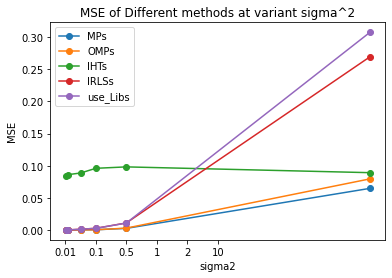

In [31]:
plt.figure()
plt.plot(sigma2s, MSE_MPs, '-o',label="MPs")
plt.plot(sigma2s, MSE_OMPs, '-o',label="OMPs")
plt.plot(sigma2s, MSE_IHTs, '-o',label="IHTs")
plt.plot(sigma2s, MSE_IRLSs, '-o',label="IRLSs")
plt.plot(sigma2s, MSE_use_Libs, '-o',label="use_Libs")
plt.legend()
plt.xticks(range(len(sigma2s)),sigma2s)
plt.xlabel("sigma2")
plt.ylabel("MSE")
plt.title("MSE of Different methods at variant sigma^2")

**Réponse** : On peut voir que la robustesse de chaque méthode sous l'influence de différents niveaux de bruit. Parmi eux, les méthodes de la bibliothèque IRLS et cvxpy ont la robustesse la plus faible, et leur MSE augmente considérablement lorsque le bruit devient important, tandis que les trois autres algorithmes ont une plus grande robustesse lorsque nous utilisons différentes variances de bruit $σ^2$ . On peut constater que les méthodes MP et OMP ont une grande précision de reconstruction et une grande robustesse lorsque l'observation est bruyante.